## 5 - Working With Feature Geometries

GPlately can be used to read, process and plot geological features contained in ESRI Shapefiles (with file extension .shp) and GPML files (with file extension .gpml or .gpmlz). In this notebook, we will look at:
- A common Shapely and Cartopy issue with plotting invalid shapely geometries;
- How GPlately reads shapefiles and extracts valid shapely geometries to resolve the above;
- Plotting shapely geometries using GPlately's `PlotTopologies` object
- Plotting extra .gpml features such as:
    - Polylines
    - Polygons
    - Points

_(These GPML files are sourced from EarthByte's GPlates 2.3 Dataset library: https://www.earthbyte.org/gplates-2-3-software-and-data-sets/  and loaded in with GPlately's `DataServer` object.)_

Let's set up all our packages:

In [1]:
import gplately

import numpy as np
import pygplates
import glob, os
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

GPlately simplifies the process of:
- reconstructing a set of shapefile or gpml features with pygplates;
- generating Shapely MultiPolygon, MultiPoint and/or MultiLine geometries from reconstructed features; and
- adding these features onto GeoAxis maps

All these functionalities are nested in GPlately's `PlotTopologies` object. To call `PlotTopologies`, you need to supply paths to any __coastline, continent__ and __continent-ocean-boundary (COB)__ shapefiles you want to plot, along with the __reconstruction time__ you want and the __plate motion model__ to reconstruct with. 

We'll first construct the __plate motion model__ using GPlately's `PlateReconstruction` object. You need paths to a rotation model, features/a feature collection and static polygons.

In this notebook, we'll use data loaded in with GPlately's `DataServer` from a study by Muller et al. (2019) (Source: https://www.earthbyte.org/muller-et-al-2019-deforming-plate-reconstruction-and-seafloor-age-grids-tectonics/).

In [2]:
# Initialise gplately data server and extract data from Muller et al. 2019
gdownload = gplately.download.DataServer("Muller2019")
rotation_model, topology_features, static_polygons = gdownload.get_plate_reconstruction_files()

# Create the plate motion model!
model = gplately.PlateReconstruction(rotation_model, topology_features, static_polygons)

.gpml static files were not found. Attempting to find .shp versions instead...
Found 1 .shp version(s) of static files.


We'll use this plate motion model as an attribute for our `PlotTopologies` object along with a reconstruction time and some coastline, continent and continent-ocean-boundary (COB) shapefile paths (with extension .shp) from the Muller et al. (2019) zip file.

We will obtain these shapefile paths on-the-fly with GPlately's `DataServer` object.

The shapefile geometries we give to the `PlotTopologies` object are reconstructed to the given time. This prepares these geometries to be turned into plottable Shapely feature lines, polygons and/or points.

In [3]:
# Obtain Muller et al. 2019 geometries with gdownload
coastlines, continents, COBs = gdownload.get_topology_geometries()

# Call the PlotTopologies object - this reconstructs the coastlines, continents and COBs. 
time = 50
gplot = gplately.plot.PlotTopologies(model, time, coastlines, continents, COBs)

.gpml coastline files were not found. Attempting to find .shp versions instead...
Found 1 .shp version(s) of coastline files.
.gpml continent files were not found. Attempting to find .shp versions instead...
Found 1 .shp version(s) of continent files.
.gpml cob files were not found. Attempting to find .shp versions instead...
Found 1 .shp version(s) of cob files.


### A common Shapely and Cartopy plotting issue

Before we look at how to use GPlately to process shapefiles, let's look at a common Shapely and Cartopy plotting issue. Sometimes the facecolors of certain shapely features "bleed" out of their geometries into the ocean. Other times we may notice some Shapely geometries are missing from our maps. This can occur if we read a shapefile and plot its geometries without removing invalid polylines, polygons and points. An example is as follows:

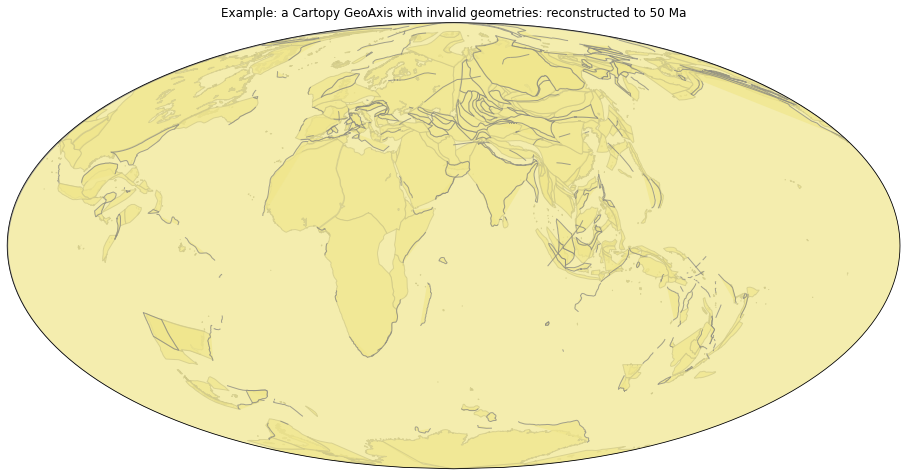

In [4]:
# The shapefiles we just used above - we'll need to use the 0th element of these lists because 
# The variables 'coastlines', 'continents', 'COBs' are lists that include the shapefile path strings.
shapefile_list = [coastlines[0], continents[0], COBs[0]]

# Define our GeoAxis map
ax_map = plt.figure(figsize=(16,12)).add_subplot(111, projection=ccrs.Mollweide(central_longitude=60))
plt.title('Example: a Cartopy GeoAxis with invalid geometries: reconstructed to %i Ma' % (time))

# Loop through all shapefile paths, extract their geometries and plot them (note no extra measures taken to
# avoid invalid geometries)
import cartopy.io.shapereader as shpreader
for shpfile in shapefile_list:
    shp_info = shpreader.Reader(shpfile)
    for record, geometry in zip(shp_info.records(), shp_info.geometries()):
        ax_map.add_geometries([geometry], ccrs.PlateCarree(), facecolor='khaki', alpha=0.7, edgecolor='grey')

### How GPlately filters through valid Shapely geometries

Don't fret - GPlately avoids this issue! The `PlotTopologies` object plots these continent, coastline and COB shapefile features by only taking valid geometries for plottng. If you're interested in knowing how, GPlately:
- __Wraps geometries to the dateline:__ This is done by splitting a polyline/polgyon into multiple polylines/polygons at the dateline.  This is to avoid horizontal lines being formed between polylines at longitudes of -180 and 180 degrees.
- __Clips geometries close to the poles:__ Any shapely geometries that lie at latitudes above +89 degrees and below -89 degrees are removed from the feature list because they tend to create artefacts. 
- __Ensures exterior coordinates of Shapely geometries are ordered anti-clockwise:__ This is to ensure compatibility with Cartopy.

This is all taken care of whenever you call "gplot.plot_X", so your plots will show correctly!

### Plotting shapely geometries using GPlately's PlotTopologies object

Let's plot the supplied shapefiles with GPlately:

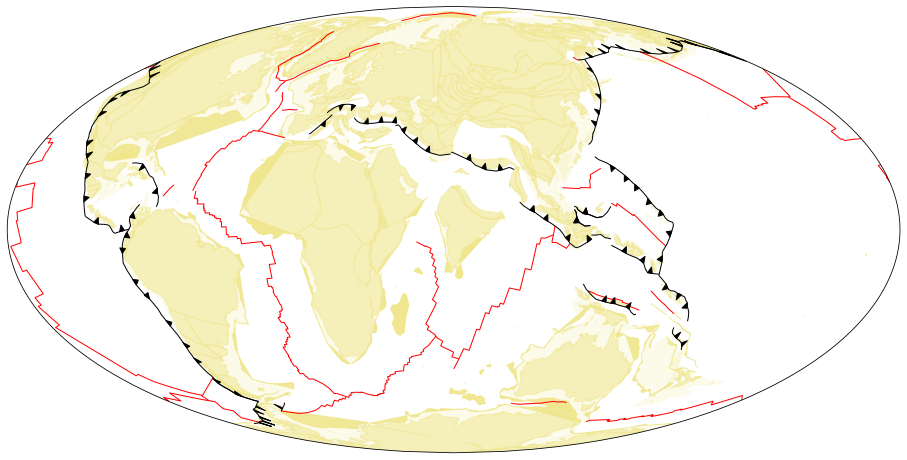

In [5]:
# If you want to update the reconstruction time
gplot.time = 50

# Set up GeoAxis, plot topologies - notice no color bugs!
ax2 = plt.figure(figsize=(16,12)).add_subplot(111, projection=ccrs.Mollweide(central_longitude=60))
gplot.plot_continents(ax2, facecolor='khaki', alpha=0.2)
gplot.plot_continent_ocean_boundaries(ax2, color='khaki', alpha=0.9)
gplot.plot_coastlines(ax2, color='khaki', alpha=0.5)
gplot.plot_ridges_and_transforms(ax2, color='red')
gplot.plot_trenches(ax2, color='k')
gplot.plot_subduction_teeth(ax2, color='k')

### Plotting additional GPML features: Polylines

Let's plot some topologies that define the tectonic fabric of global seafloors at present day. These consist of global fracture zones (FZs), v-shaped structures (VANOMs), discordant zones (DZs), fracture zones (hand-traced with less certainty) (FZLCs), unclassified V-anomalies (UNCVs) and extinct ridges. These are polylines that are digitised from vertical gravity gradient (VGG) maps.

Let's load these features in with GPlately's `DataServer` from the "SeafloorFabric" zip folder on EarthByte's WebDAV server.

In [6]:
# Set present day
time = 0 # Ma

# Collect all gpmlz files that make up the seafloor fabric dataset
zip_url = "https://www.earthbyte.org/webdav/ftp/earthbyte/GPlates/SampleData_GPlates2.2/Individual/FeatureCollections/SeafloorFabric.zip"
gpmlz_ext = ".gpmlz"
seafloor_filenames = gplately.download.fetch_from_zip(zip_url, gpmlz_ext)

Our next step is to reconstruct these features by calling the 'reconstruct' function (which belongs to our plate `model` (the `PlateReconstruction` object). Once these features are reconstructed, we call the 'shapelify_feature_lines' method (which belongs to the GPlately `plot` module) to turn these features into Shapely polylines that are suitable for plotting.

We want to identify each feature by colour, so these steps are done in a for loop. Each seafloor feature is plotted onto a Cartopy GeoAxis map.

Fracture Zones consist of 4303 polylines and are plotted in the colour: powderblue
V-Shaped Structures consist of 12 polylines and are plotted in the colour: k
Discordant Zones consist of 700 polylines and are plotted in the colour: m
Fracture Zones (less certainty) consist of 141 polylines and are plotted in the colour: g
Unclassified V-Anomalies consist of 113 polylines and are plotted in the colour: b
Extinct Ridges consist of 264 polylines and are plotted in the colour: y


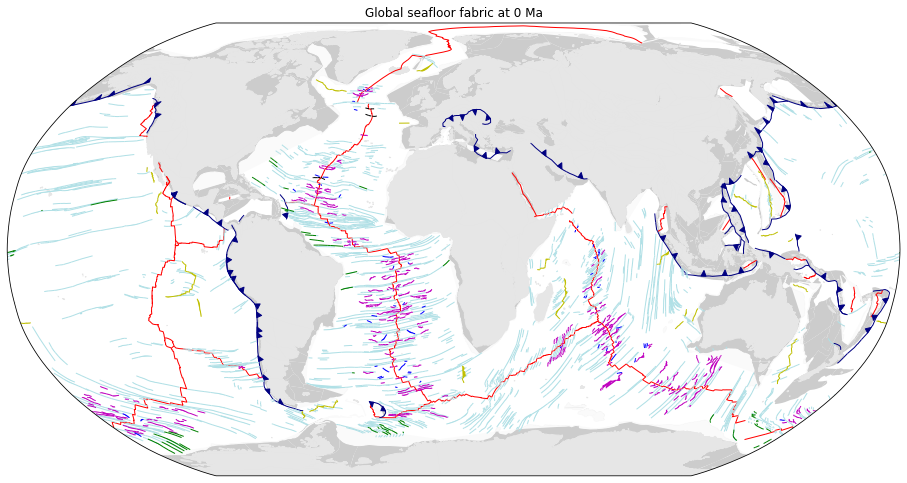

In [7]:
# Set up GeoAxis and plot shapefile topologies
ax2 = plt.figure(figsize=(16,12)).add_subplot(111, projection=ccrs.Robinson(central_longitude=10))
gplot.time = time
gplot.plot_continents(ax2, facecolor='0.8')
gplot.plot_continent_ocean_boundaries(ax2, color='0.98')
gplot.plot_coastlines(ax2, color='0.9')
gplot.plot_ridges_and_transforms(ax2, color='r')
gplot.plot_trenches(ax2, color='navy')
gplot.plot_subduction_teeth(ax2, color='navy')
plt.title('Global seafloor fabric at %i Ma' % (time))

# Seafloor fabric topology identification variables
colours = ['powderblue', 'k', 'm', 'g', 'b', 'y']
feat = ['Fracture Zones', 'V-Shaped Structures', 'Discordant Zones', 'Fracture Zones (less certainty)', 
        'Unclassified V-Anomalies', 'Extinct Ridges']

# Loop through all seafloor fabric filenames, reconstruct each topology and plot onto ax2 using GPlately
for i, file in enumerate(seafloor_filenames):
    seafloor_topology = pygplates.FeatureCollection(file)
    reconstructed_seafloor_topology = model.reconstruct(seafloor_topology, time)
    polylines = gplately.plot.shapelify_feature_lines(reconstructed_seafloor_topology)
    print('%s consist of %i polylines and are plotted in the colour: %s' % (feat[i], len(polylines), colours[i]))
    ax2.add_geometries(polylines, crs=ccrs.PlateCarree(), facecolor=colours[i], edgecolor=colours[i])
    

If you have moviepy available, you can create a gif that illustrates the generation of tectonic seafloor fabric over many Ma. Let's reconstruct plate movements over 150 Ma in intervals of 10 Ma.

In [8]:
# Seafloor fabric topology identification variables
colours = ['powderblue', 'k', 'm', 'g', 'b', 'y']
feat = ['Fracture Zones', 'V-Shaped Structures', 'Discordant Zones', 'Fracture Zones (less certainty)', 
        'Unclassified V-Anomalies', 'Extinct Ridges']

# Time variables
oldest_seed_time = 150 # Ma
time_step = 10 # Ma

# Create a plot for each 10 Ma interval
for time in np.arange(oldest_seed_time,0.,-time_step):
    
    # Set up GeoAxis and plot shapefile topologies
    ax5 = plt.figure(figsize=(16,12)).add_subplot(111, projection=ccrs.Robinson(central_longitude=10))
    gplot.time = time
    gplot.plot_continents(ax5, facecolor='0.8')
    gplot.plot_continent_ocean_boundaries(ax5, color='0.98')
    gplot.plot_coastlines(ax5, color='0.9')
    gplot.plot_ridges_and_transforms(ax5, color='r')
    gplot.plot_trenches(ax5, color='navy')
    gplot.plot_subduction_teeth(ax5, color='navy')
    plt.title('Global seafloor fabric at %i Ma' % (time))

    print(f'working on time {time}')
    
    # Loop through all seafloor fabric filenames, reconstruct each topology and plot onto ax2 using GPlately
    for i, file in enumerate(seafloor_filenames):
        seafloor_topology = pygplates.FeatureCollection(file)
        reconstructed_seafloor_topology = model.reconstruct(seafloor_topology, time)
        polylines = gplately.plot.shapelify_feature_lines(reconstructed_seafloor_topology)
        ax5.add_geometries(polylines, crs=ccrs.PlateCarree(), facecolor=colours[i], edgecolor=colours[i])
        
    plt.savefig('/tmp/seafloor_fabric_%d_Ma.png' % time)
    plt.close()
    print('Image for %d Ma saved' % time)
    

working on time 150.0
Image for 150 Ma saved
working on time 140.0
Image for 140 Ma saved
working on time 130.0
Image for 130 Ma saved
working on time 120.0
Image for 120 Ma saved
working on time 110.0
Image for 110 Ma saved
working on time 100.0
Image for 100 Ma saved
working on time 90.0
Image for 90 Ma saved
working on time 80.0
Image for 80 Ma saved
working on time 70.0
Image for 70 Ma saved
working on time 60.0
Image for 60 Ma saved
working on time 50.0
Image for 50 Ma saved
working on time 40.0
Image for 40 Ma saved
working on time 30.0
Image for 30 Ma saved
working on time 20.0
Image for 20 Ma saved
working on time 10.0
Image for 10 Ma saved


In [9]:
import moviepy.editor as mpy

frame_list = []

for time in np.arange(oldest_seed_time,0.,-time_step):
    frame_list.append('/tmp/seafloor_fabric_%d_Ma.png' % time)
    

clip = mpy.ImageSequenceClip(frame_list, fps=5)
clip.write_gif('/tmp/seafloor_fabric_movie.gif')

MoviePy - Building file /tmp/seafloor_fabric_movie.gif with imageio.


The movie will show up in a few seconds. Please be patient...


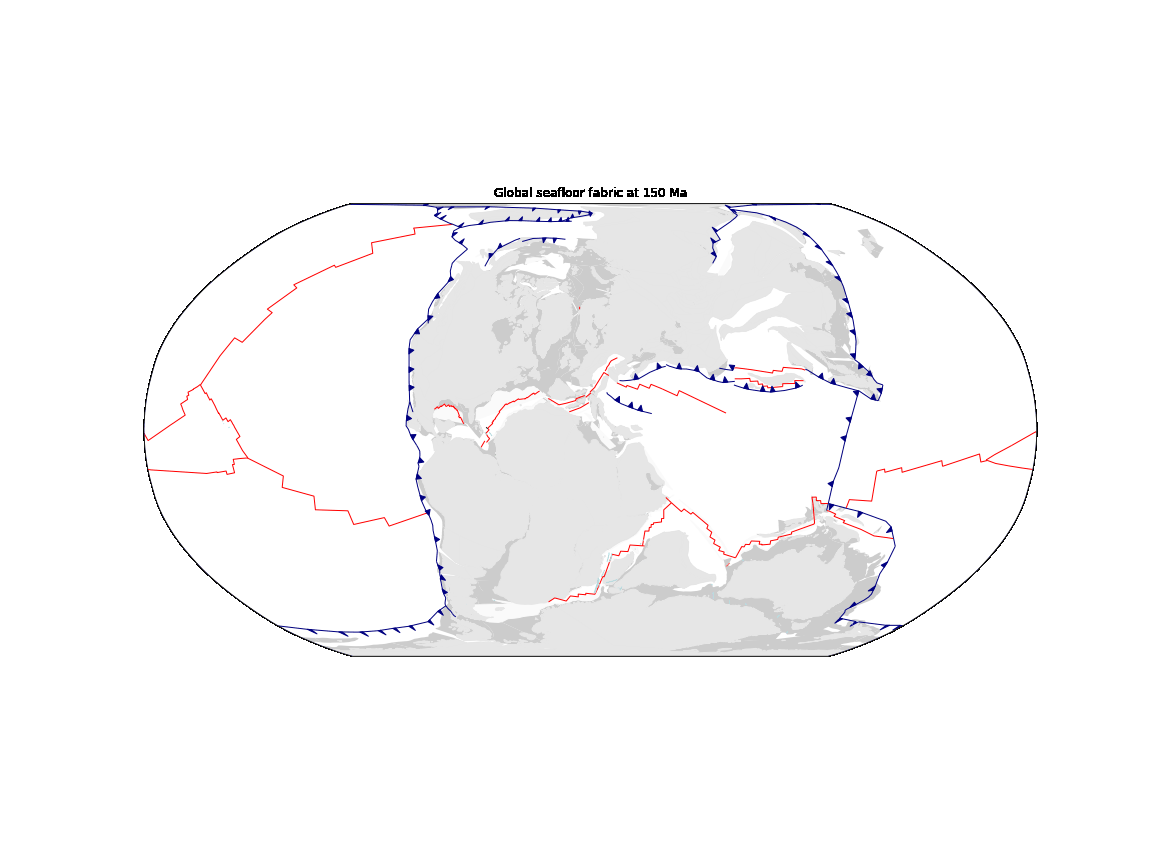

In [10]:
from IPython.display import Image
print('The movie will show up in a few seconds. Please be patient...')
with open('/tmp/seafloor_fabric_movie.gif','rb') as f:
    display(Image(data=f.read(), format='png', width = 3000, height = 1000))

### Plotting additional GPML features: Polygons

Let's plot some topologies that mark global __volcanic provinces__ at present day. This data is adapted from a study on "The interplay between the eruption and weathering of Large Igneous Provinces and the deep-time carbon cycle" by Johansson et al. (2018). We'll also plot a set of global __large igneous provinces (LIPs)__ adapted from a study on the "Long-term interaction between mid-ocean ridges and mantle plumes" by Whittaker et al. (2015).

We'll obtain these files using GPlately's `DataServer` object by providing the link to the zip folder and the ".gpmlz" file extension.

In [10]:
zip_url = "https://www.earthbyte.org/webdav/ftp/earthbyte/GPlates/SampleData_GPlates2.2/Individual/FeatureCollections/LargeIgneousProvinces_VolcanicProvinces.zip"
gpmlz_ext = ".gpmlz"
# Locate the Johansson et al. (2018) and Whittaker et al. (2015) gpmlz files containing volcanic provinces & LIPs
topology_filenames = gplately.download.fetch_from_zip(zip_url, gpmlz_ext)

Since these topologies will become Shapely polygons, we'll need to use `shapelify_feature_polygons`. Moreover, since we are plotting multiple features onto a single GeoAxis map, it'll be useful to:
- Create a pygplates feature
- Reconstruct topologies to a specific geological time
- Turn topologies into shapely polygons

within a for loop through each topology file. This kind of for loop will be useful for specifying keyword arguments unique to each for topology type (i.e. one plotting colour for volcanic provinces and another for LIPs).

Volcanic provinces consist of 2548 polygons and are plotted in the colour: cyan
Large igneous provinces consist of 101 polygons and are plotted in the colour: maroon


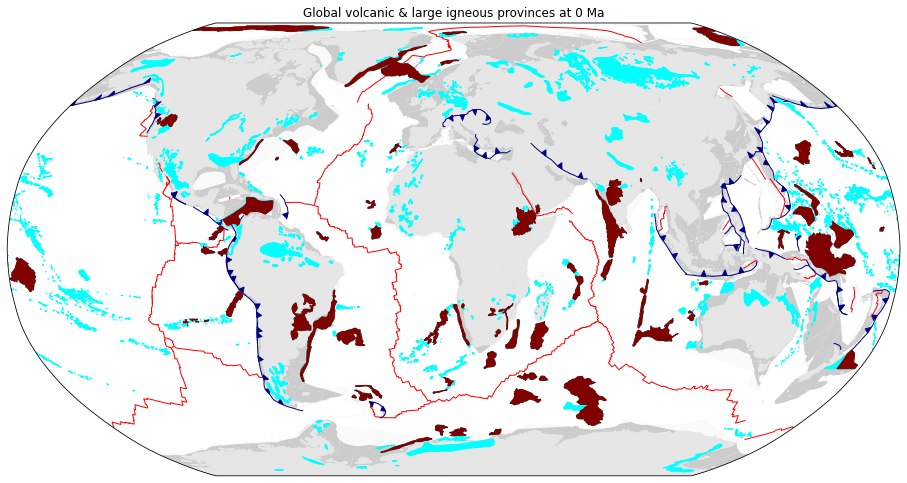

In [11]:
# Set time to present day
time = 0

# Set up GeoAxis and plot shapefile topologies to present day
ax3 = plt.figure(figsize=(16,12)).add_subplot(111, projection=ccrs.Robinson(central_longitude=10))
gplot.time = time
gplot.plot_continents(ax3, facecolor='0.8')
gplot.plot_continent_ocean_boundaries(ax3, color='0.98')
gplot.plot_coastlines(ax3, color='0.9')
gplot.plot_ridges_and_transforms(ax3, color='r')
gplot.plot_trenches(ax3, color='navy')
gplot.plot_subduction_teeth(ax3, color='navy')
plt.title('Global volcanic & large igneous provinces at %i Ma' % (time))

# Let's plot the volcanic provinces, then the LIPs
topology_filenames = np.flip(topology_filenames)

# Loop through all seafloor fabric filenames, reconstruct each topology and plot onto ax2 using GPlately
feat = ["Volcanic provinces", "Large igneous provinces"]
colours = ['cyan', 'maroon']
for i, file in enumerate(topology_filenames):
    feat_topology = pygplates.FeatureCollection(file)
    reconstructed_topology = model.reconstruct(feat_topology, time)
    polygons = gplately.plot.shapelify_feature_polygons(reconstructed_topology)
    print('%s consist of %i polygons and are plotted in the colour: %s' % (feat[i], len(polygons), colours[i]))
    ax3.add_geometries(polygons, crs=ccrs.PlateCarree(), facecolor=colours[i], edgecolor=colours[i])

### Plotting additional GPML features: Points

Let's plot some point topologies that mark present day __surface hotspot/plume locations__. These data are adapted from a Whittaker et al. (2015) study on the "Long-term interaction between mid-ocean ridges and mantle plumes". 

These point locations are split into Pacific and Indo/Atlantic domains and were compiled from studies by Montelli et al. (2004), Courtillot et al. 2003, Anderson and Schramm (2005) and Steinberger et al. (2000). Any plume points are separated by 500 km or less have been combined into an average point location.

Let's obtain these topology files with GPlately's DataServer and collate them into a pygplates Feature Collection. Once this is done we'll need to reconstruct these point features using the `PlateReconstruction` object (namely through "model.reconstruct" as follows):

In [13]:
# Set reconstruction time to present day
time = 0 # Ma

# Obtain file containing hotspot and plume locations
zip_url = "https://www.earthbyte.org/webdav/ftp/earthbyte/GPlates/SampleData_GPlates2.2/Individual/FeatureCollections/Hotspots.zip"
file_ext = ".gpmlz"
hotspot_plume_filenames = gplately.download.fetch_from_zip(zip_url, file_ext)

# ***If using Mac, ignore the file extracted from the __MACOSX folder
hotspot_plume_filenames = gplately.download.ignore_macOSX(hotspot_plume_filenames)
        
# Reconstruct hotspot and plume point locations to present day.
# Use [0] to extract string from list
hotspot_plume_features = pygplates.FeatureCollection(hotspot_plume_filenames[0])
reconstructed_hotspot_plumes = model.reconstruct(hotspot_plume_features, time)

Plotting point data requires a matplotlib scatterplot. You'll need two arrays: 1 for the latitudes of the point locations, and 1 for the longitudes of the point locations. We can use pygplates to extract these lat-lon coordinates. Once these arrays are created, we can plot them using "scatter" onto a GeoAxis map! 

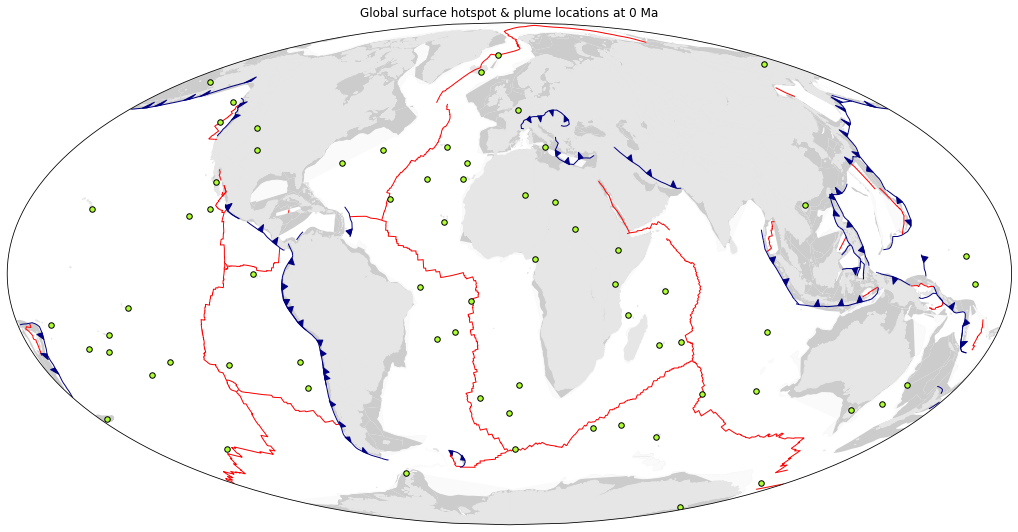

In [14]:
# Extract lat-lon coordinates of point locations
plon = np.zeros(len(reconstructed_hotspot_plumes))
plat = np.zeros(len(reconstructed_hotspot_plumes))
for i, feature in enumerate(reconstructed_hotspot_plumes):
    geometry = feature.get_reconstructed_geometry()
    plat[i], plon[i] = geometry.to_lat_lon()
    
# Set up GeoAxis, plot shapefile topologies and hotspot/plume point features to present day
ax4 = plt.figure(figsize=(18,10)).add_subplot(111, projection=ccrs.Mollweide(central_longitude=0))
gplot.time = time
gplot.plot_continents(ax4, facecolor='0.8')
gplot.plot_continent_ocean_boundaries(ax4, color='0.98')
gplot.plot_coastlines(ax4, color='0.9')
gplot.plot_ridges_and_transforms(ax4, color='r')
gplot.plot_trenches(ax4, color='navy')
gplot.plot_subduction_teeth(ax4, color='navy')
plt.title('Global surface hotspot & plume locations at %i Ma' % (time))
ax4.scatter(plon, plat, transform=ccrs.PlateCarree(), marker='o', color='greenyellow', edgecolor='k', s=30, zorder=2)
ax4.set_global()

### Dataset sources/citations

GPML feature topology data used for this notebook have been sourced from EarthByte's GPlates 2.3 software and dataset database: https://www.earthbyte.org/gplates-2-3-software-and-data-sets/

__Global seafloor fabric:__
- Matthews, K.J., Müller, R.D., Wessel, P. and Whittaker, J.M., 2011. The tectonic fabric of the ocean basins. Journal of Geophysical Research, 116(B12): B12109, DOI: 10.1029/2011JB008413.

__Volcanic provinces:__
- Johansson, L., Zahirovic, S., and Müller, R. D., 2018, The interplay between the eruption and weathering of Large Igneous Provinces and the deep-time carbon cycle: Geophysical Research Letters, doi:10.1029/2017GL076691.
- Bryan, S. E., and Ernst, R. E., 2008, Revised definition of large igneous provinces (LIPs): Earth-Science Reviews, v. 86, no. 1, p. 175-202, doi:10.1016/j.earscirev.2007.08.008.
- Courtillot, V. E., and Renne, P. R., 2003, On the ages of flood basalt events: Comptes Rendus Geoscience, v. 335, no. 1, p. 113-140, doi:10.1016/S1631-0713(03)00006-3.

__Large igneous provinces:__
- Whittaker, J., Afonso, J., Masterton, S., Müller, R., Wessel, P., Williams, S., and Seton, M., 2015, Long-term interaction between mid-ocean ridges and mantle plumes: Nature Geoscience, v. 8, no. 6, p. 479-483, doi: 10.1038/ngeo2437.

__Surface hotspot + plume locations:__
- Whittaker, J., Afonso, J., Masterton, S., Müller, R., Wessel, P., Williams, S., and Seton, M., 2015, Long-term interaction between mid-ocean ridges and mantle plumes: Nature Geoscience, v. 8, no. 6, p. 479-483, doi: 10.1038/ngeo2437.